In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as utils
from torchvision import transforms, models
import pretrainedmodels
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
import time
import os
import copy
import torchvision
import random
import cv2

In [2]:
is_cuda = torch.cuda.is_available()
is_cuda

True

# Utiles

In [3]:
def misimshow(inp,name,index):
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title('misclassified as %s' %(name))
    #plt.savefig('D:/capstone/split_patient/S2/Output/misclassified/5fold/%d.jpg'%(index))

def test_imshow(inp):
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    
def num_of_label(loader):
    global n
    label_list = []
    n=0
    while n < len(loader):
        if loader == trainloader.dataset:
            set = 'Train set'
            label_lists = np.array(train[n][1])
            label_list = np.append(label_list,label_lists)
            n+=1
        elif loader == validloader.dataset:
            set = 'Valid set'
            label_lists = np.array(valid[n][1])
            label_list = np.append(label_list,label_lists)
            n+=1
        elif loader == testloader.dataset:
            set = 'Test set'
            label_lists = np.array(test[n][1])
            label_list = np.append(label_list,label_lists)
            n+=1
    unique, counts = np.unique(label_list, return_counts=True)
    print('{} : {}'.format(set,dict(zip(unique, counts))))
    
def result_graph():
    plt.figure(1)
    
    plt.subplot(2,1,1)
    plt.plot(range(1,len(train_accuracy)+1),train_accuracy,'b',label = 'train accuracy')
    plt.plot(range(1,len(val_accuracy)+1),val_accuracy,'r',label = 'valid accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('Acc Curve')
    plt.legend()
    plt.subplots_adjust(hspace=0.7)
    
    plt.subplot(2,1,2)
    plt.plot(range(1,len(train_losses)+1),train_losses,'b',label = 'train loss')
    plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'valid loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss Curve')
    plt.legend()

class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience  = patience
        self.verbose = verbose
 
    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss
 
        return False

def confmat(loader):
    model.load_state_dict(torch.load('s2-s3_1fold.pt'))
    model.eval()
    volatile=True
    running_correct = 0
    nb_classes = 2
    index = 0
    roc_max_diff, roc_target = [],[]

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for data,target in loader:
            PIL_image = data
            inputs,target = data.cpu(),target.cpu()
            if loader == validloader:
                length = len(target)
                for v in range(length):
                    data_orin = transform_normalize(data[v])
                    if v == 0:
                        data_all = data_orin.unsqueeze(0)
                    if v != 0:
                        data_orin = data_orin.unsqueeze(0)
                        data_all = torch.cat((data_all,data_orin),0)
                if is_cuda:
                #원본에 대한 결과값 , 16개의 원본 배치에 대한 값을 outputs_original에 받음
                    inputs_original, target = data_all.cuda() , target.cuda()
                inputs_original , target = Variable(inputs_original),Variable(target)
                outputs_original = model(inputs_original)
                outputs_original = torch.sigmoid(outputs_original)
                
                #length = len(target)
                #if is_cuda:
                #    img,target = img.cuda(),target.cuda()

                for i in range(length):
                    img = PIL_image[i]
                    img = torchvision.transforms.ToPILImage()(img)
                    #시작점 랜덤하게 잡기(지금은 임의로 29*29점을 초기 값으로 잡음)
                    random_init_W = 29
                    random_init_H = 29
                    # 랜덤 크롭 실행
                    img_random_crop = torchvision.transforms.functional.resized_crop(img,random_init_W,random_init_H,239,239,(299,299))
                    img_random_crop = transform(img_random_crop)
                    img_random_crop = img_random_crop.unsqueeze(0)
                    # V Flip
                    img_VFlip = torchvision.transforms.functional.vflip(img)
                    img_VFlip = transform(img_VFlip)
                    img_VFlip = img_VFlip.unsqueeze(0)
                    # H Flip
                    img_HFlip = torchvision.transforms.functional.hflip(img)
                    img_HFlip = transform(img_HFlip)
                    img_HFlip = img_HFlip.unsqueeze(0)
                    # rotate
                    img_rotate = torchvision.transforms.functional.rotate(img,90)
                    img_rotate = transform(img_rotate)
                    # 차원 확장(배치를 쌓기위해)
                    img_rotate = img_rotate.unsqueeze(0)
                    concat_image = torch.cat((img_random_crop, img_VFlip, img_HFlip, img_rotate), 0)
                    concat_image =  concat_image.cuda()
                    concat_image = Variable(concat_image)
                    
                    outputs = model(concat_image)
                    outputs = torch.sigmoid(outputs)
                   
                #원본 + 패치들의 값들을 더하기
                    for j in range(4):
                        outputs_original[i,0] += outputs[j,0]
                        outputs_original[i,1] += outputs[j,1]
                        
                    outputs_original[i] = outputs_original[i]/5

                _, preds = torch.max(outputs_original, 1)
                running_correct += preds.eq(target.data.view_as(preds)).cpu().sum() 
                
                preds,target,inputs = preds.cpu(),target.cpu(),inputs.cpu()
                mpreds,mtarget,minputs = preds.numpy(),target.numpy(),inputs.numpy()
                for m in range(len(mpreds)):
                    index = index +1
                    o = (mpreds[m]==mtarget[m]).astype(np.float32)
                    if o != 1:
                        mis = mpreds[m]
                        if mis != 0:
                            name = 'melanoma'
                        else:
                            name = 'benign'        
                        misimshow(minputs[m],name,index)
                        
            if loader == testloader:
                length = len(target)
                for v in range(length):
                    data_orin = transform_normalize(data[v])
                    if v == 0:
                        data_all = data_orin.unsqueeze(0)
                    if v != 0:
                        data_orin = data_orin.unsqueeze(0)
                        data_all = torch.cat((data_all,data_orin),0)
                if is_cuda:
                #원본에 대한 결과값 , 16개의 원본 배치에 대한 값을 outputs_original에 받음
                    inputs_original, target = data_all.cuda() , target.cuda()
                inputs_original , target = Variable(inputs_original),Variable(target)
                outputs_original = model(inputs_original)
                outputs_original = torch.sigmoid(outputs_original)
                
                #length = len(target)

                for i in range(length):
                    img = PIL_image[i]
                    img = torchvision.transforms.ToPILImage()(img)
                    #시작점 랜덤하게 잡기
                    random_init_W = 29
                    random_init_H = 29 #random.randint(0,58)
                    # 랜덤 크롭 실행
                    img_random_crop = torchvision.transforms.functional.resized_crop(img,random_init_W,random_init_H,239,239,(299,299))
                    img_random_crop = transform(img_random_crop)
                    img_random_crop = img_random_crop.unsqueeze(0)
                    
                    # V Flip
                    img_VFlip = torchvision.transforms.functional.vflip(img)
                    #img_VFlip = torchvision.transforms.ToTensor()(img_VFlip)
                    img_VFlip = transform(img_VFlip)
                    img_VFlip = img_VFlip.unsqueeze(0)

                    # H Flip
                    img_HFlip = torchvision.transforms.functional.hflip(img)
                    #img_HFlip = torchvision.transforms.ToTensor()(img_HFlip)
                    img_HFlip = transform(img_HFlip)
                    img_HFlip = img_HFlip.unsqueeze(0)

                    # rotate
                    img_rotate = torchvision.transforms.functional.rotate(img,90)
                    #img_rotate = torchvision.transforms.ToTensor()(img_rotate)
                    img_rotate = transform(img_rotate)
                    # 차원 확장(배치를 쌓기위해)
                    img_rotate = img_rotate.unsqueeze(0)

                    concat_image = torch.cat((img_random_crop, img_VFlip, img_HFlip, img_rotate), 0)
                    concat_image =  concat_image.cuda()
                    concat_image = Variable(concat_image)
                    
                    outputs = model(concat_image)
                    outputs = torch.sigmoid(outputs)
                    for j in range(4):
                        outputs_original[i,0] += outputs[j,0]
                        outputs_original[i,1] += outputs[j,1]
                   #원본과 패치들의 값을 다 더한후 평균 내주기
                    
                    outputs_original[i] = outputs_original[i]/5
                    
                    #평균낸 값에서 멜라노마인 부분의 score를 쌓음
                
                    roc_max_diff = np.append(roc_max_diff,outputs_original[i,1])
            
                _, preds = torch.max(outputs_original, 1)
                running_correct += preds.eq(target.data.view_as(preds)).cpu().sum() 
                roc_target = np.append(roc_target,target)
                
            if loader == validloader:
                for t, p in zip(target.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
            if loader == testloader:   
                for t, p in zip(target.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
        accuracy = 100. * running_correct/len(loader.dataset)
                    
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            s[i][j] = confusion_matrix[i][j]
    TN,FP,FN,TP = s[0][0],s[0][1],s[1][0],s[1][1]
    PE = ((TP+FN)/(len(loader.dataset)))*((TP+FP)/(len(loader.dataset)))+((FP+TN)/(len(loader.dataset)))*((FN+TN)/(len(loader.dataset)))
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    print('TP = {}, FP = {}, TN = {}, FN = {}'.format(TP,FP,TN,FN))
    print('Specifity = {:.4f}, Sensitivity = {:.4f}'.format(TN/(TN+FP),TP/(TP+FN)))
    print('F1 score = {:.4f}'.format(TP/(TP+(FN+FP)/2)))
    if loader == testloader:
        print('Test Acc = {:.4f}'.format(accuracy))
        accuracy = accuracy.type(torch.FloatTensor)
        PE = PE.type(torch.FloatTensor)
        Kappa = (0.01*accuracy-PE)/(1.0-PE)
        Kappa = Kappa.type(torch.FloatTensor)
        print('cohens kappa = {:.4f}'.format(Kappa))
        fpr, tpr, _ = roc_curve(roc_target,roc_max_diff)
        roc_auc = auc(fpr,tpr)
        np.save(output_path + "fpr1.npy", fpr)
        np.save(output_path + "tpr1.npy", tpr)
        np.save(output_path + "auc1.npy", roc_auc)
        np.save(output_path + "roc_target1.npy", roc_target)
        np.save(output_path + "roc_max_diff1.npy", roc_max_diff)

# Network

In [4]:
fine_tune = False
model = models.resnet50(pretrained=True)

if not fine_tune:
    for parameter in model.parameters():
        parameter.requires_grad = False

n_features = model.fc.in_features
model.dropout = nn.Dropout(p=0.5)
model.fc = nn.Linear(n_features, 2)
##for vgg
#model.classifier[-1] = nn.Linear(in_features=4096, out_features=2)

if torch.cuda.is_available():
    model = model.cuda()

model

In [5]:
learning_rate = 0.1
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9,nesterov=True)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [6]:
def fit(epoch,model,data_loader,phase='train',volatile=False):
    if phase == 'train':
        exp_lr_scheduler.step()
        model.train()
    if phase == 'valid':
        model.eval()   
    running_loss = 0.0
    running_correct = 0
    for batch_idx , (data,target) in enumerate(data_loader):
        PIL_image = data
        inputs,target = data.cpu(),target.cpu()
        if phase == 'valid':
            with torch.no_grad():
                length = len(target)
                for v in range(length):
                    data_orin = transform_normalize(data[v])
                    if v == 0:
                        data_all = data_orin.unsqueeze(0)
                    if v != 0:
                        data_orin = data_orin.unsqueeze(0)
                        data_all = torch.cat((data_all,data_orin),0)
                if is_cuda:
                #원본에 대한 결과값 , 16개의 원본 배치에 대한 값을 outputs_original에 받음
                    inputs_original, target = data_all.cuda() ,target.cuda()
                inputs_original , target = Variable(inputs_original),Variable(target)
                outputs_original = model(inputs_original)
                outputs_original = torch.sigmoid(outputs_original)
                
                #length = len(target)
                #if is_cuda:
                #    img,target = img.cuda(),target.cuda()

                for i in range(length):
                    img = PIL_image[i]
                    img = torchvision.transforms.ToPILImage()(img)
                    #시작점 랜덤하게 잡기
                    random_init_W = 29
                    random_init_H = 29
                    # 랜덤 크롭 실행
                    img_random_crop = torchvision.transforms.functional.resized_crop(img,random_init_W,random_init_H,239,239,(299,299))
                    #img_random_crop = torchvision.transforms.ToTensor()(img_random_crop)
                    img_random_crop = transform(img_random_crop)
                    img_random_crop = img_random_crop.unsqueeze(0)
                    
                    # V Flip
                    img_VFlip = torchvision.transforms.functional.vflip(img)
                    #img_VFlip = torchvision.transforms.ToTensor()(img_VFlip)
                    img_VFlip = transform(img_VFlip)
                    img_VFlip = img_VFlip.unsqueeze(0)

                    # H Flip
                    img_HFlip = torchvision.transforms.functional.hflip(img)
                    #img_HFlip = torchvision.transforms.ToTensor()(img_HFlip)
                    img_HFlip = transform(img_HFlip)
                    img_HFlip = img_HFlip.unsqueeze(0)

                    # rotate
                    img_rotate = torchvision.transforms.functional.rotate(img,90)
                    #img_rotate = torchvision.transforms.ToTensor()(img_rotate)
                    img_rotate = transform(img_rotate)
                    # 차원 확장(배치를 쌓기위해)
                    img_rotate = img_rotate.unsqueeze(0)

                    concat_image = torch.cat((img_random_crop, img_VFlip, img_HFlip, img_rotate), 0)
                    concat_image =  concat_image.cuda()
                    concat_image = Variable(concat_image)

                    outputs = model(concat_image)
                    outputs = torch.sigmoid(outputs)
                    
                    #원본 + 패치들의 값들을 더하기
                    for j in range(4):
                        outputs_original[i,0] += outputs[j,0]
                        outputs_original[i,1] += outputs[j,1]

                    outputs_original[i] = outputs_original[i]/5

                loss = criterion(outputs_original,target)  
                running_loss += loss.data.item()
                _, preds = torch.max(outputs_original, 1)
                running_correct += preds.eq(target.data.view_as(preds)).cpu().sum() 
        
        if phase == 'train':
            if is_cuda:
                inputs,target = data.cuda(),target.cuda()
            inputs , target = Variable(inputs,volatile),Variable(target)
            optimizer.zero_grad()
            
            output = model(inputs)
            loss = criterion(output,target)  
            running_loss += loss.data.item()
            preds = output.data.max(dim=1,keepdim=True)[1]
            running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'train':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, loss, accuracy))
    return loss,accuracy

# Load Data & Train


Epoch 0/399
----------
train Loss: 0.1899 Acc: 86.0000
valid Loss: 0.0240 Acc: 93.0000

Epoch 1/399
----------
train Loss: 0.1381 Acc: 89.0000
valid Loss: 0.0259 Acc: 89.0000

Epoch 2/399
----------
train Loss: 0.1337 Acc: 90.0000
valid Loss: 0.0228 Acc: 94.0000

Epoch 3/399
----------
train Loss: 0.1147 Acc: 90.0000
valid Loss: 0.0221 Acc: 95.0000

Epoch 4/399
----------
train Loss: 0.1157 Acc: 91.0000
valid Loss: 0.0216 Acc: 96.0000

Epoch 5/399
----------
train Loss: 0.1017 Acc: 91.0000
valid Loss: 0.0228 Acc: 96.0000

Epoch 6/399
----------
train Loss: 0.1084 Acc: 92.0000
valid Loss: 0.0215 Acc: 97.0000

Epoch 7/399
----------
train Loss: 0.1108 Acc: 92.0000
valid Loss: 0.0216 Acc: 96.0000

Epoch 8/399
----------
train Loss: 0.1173 Acc: 91.0000
valid Loss: 0.0276 Acc: 85.0000

Epoch 9/399
----------
train Loss: 0.0879 Acc: 92.0000
valid Loss: 0.0240 Acc: 91.0000

Epoch 10/399
----------
train Loss: 0.0436 Acc: 95.0000
valid Loss: 0.0214 Acc: 98.0000

Epoch 11/399
----------
train 

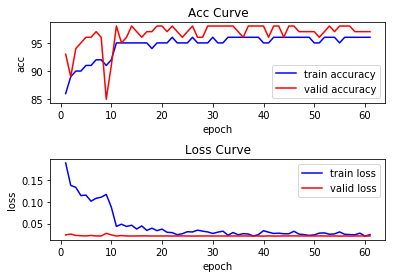

In [7]:
batch_size = 16
num_epochs = 400

output_path = 'D:/capstone/split_patient/S2-S3/Output/ROC/'
transform = transforms.Compose([transforms.Resize((299,299))
                                ,transforms.ToTensor()
                                   ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
transform_non_normalize = transforms.Compose([transforms.Resize((299,299))
                                       ,transforms.ToTensor()])
transform_normalize = transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train = ImageFolder('D:/capstone/split_patient/S2-S3/1fold/train',transform=transform)
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=5, pin_memory=True)

#S1은 transforms로 S2는 transform으로
valid = ImageFolder('D:/capstone/split_patient/S2-S3/1fold/valid',transform=transform_non_normalize)
validloader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False, num_workers=5, pin_memory=True)

test = ImageFolder('D:/capstone/split_patient/raw data/test',transform=transform_non_normalize)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=5, pin_memory=True)


init_state = copy.deepcopy(model.state_dict())
init_state_opt = copy.deepcopy(optimizer.state_dict())
init_state_lr = copy.deepcopy(exp_lr_scheduler.state_dict())

since = time.time()
avg_val_losses, avg_val_accuracy = [],[]
early_stopping = EarlyStopping(patience=20, verbose=1)


model.load_state_dict(init_state)
optimizer.load_state_dict(init_state_opt)
exp_lr_scheduler.load_state_dict(init_state_lr)


    
train_losses, train_accuracy = [],[]
val_losses, val_accuracy = [],[]
    
 
    
for epoch in range(num_epochs):
    print()
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    epoch_loss, epoch_accuracy = fit(epoch,model,trainloader,phase='train')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,validloader,phase='valid')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
        
    if early_stopping.validate(val_epoch_loss):
        break
avg_val_losses.append(val_epoch_loss)
avg_val_accuracy.append(val_epoch_accuracy)
torch.save(model.state_dict(),'s2-s3_1fold.pt')
print()
confmat(validloader)
result_graph()
    
time_elapsed = time.time() - since
print()
avg_val_accuracy, avg_val_losses = sum(avg_val_accuracy), sum(avg_val_losses)
avg_val_accuracy, avg_val_losses = np.average(avg_val_accuracy), np.average(avg_val_losses)
print('Avg valid Loss: {:.4f} Acc: {:.4f}'.format(
                avg_val_losses, avg_val_accuracy))

print('Training complete in {:.0f}m {:.0f}s'.format(
time_elapsed // 60, time_elapsed % 60))

# Test

In [8]:
#num_of_label(testloader)
confmat(testloader)

tensor([[97.,  3.],
        [10., 90.]])
tensor([0.9700, 0.9000])
TP = 90.0, FP = 3.0, TN = 97.0, FN = 10.0
Specifity = 0.9700, Sensitivity = 0.9000
F1 score = 0.9326
Test Acc = 93.0000
cohens kappa = 0.8600
